## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

2023-04-16 22:13:15.277732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-04-16 22:13:28.335175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:29.519555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:29.520153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [5]:
with np.load('data/ncbi_03/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    token_index = data['token_index'].tolist()

In [6]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(25865, 3813, 4)
(25865, 3813, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [7]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (25865, 3813, 4)
Y_data (25865, 3813, 4)


In [8]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [9]:
i = 5
print(decode_seq(X_data[i:i+1])[0])
print(decode_seq(Y_data[i:i+1])[0])

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCC

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15102942659101248953
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7276724224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2905879945422324957
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-04-16 22:13:55.185741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:55.186348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:55.186840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


2023-04-16 22:13:59.885204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:59.885822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:13:59.886317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
print(tf.__version__)

2.12.0


## Construct model

In [13]:
n_hidden = 24
n_length = 41
n_splits = X_data.shape[1] // n_length
n_splits

93

In [14]:
input_train = Input(name='parent_input', shape=(X_data.shape[1], X_data.shape[2]))
input_rand_rate = Input(name='random_input', shape=())
output_train = Input(name='child_input', shape=(Y_data.shape[1], Y_data.shape[2]))

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name='parent_input'), name='parent_input', description="created by layer 'parent_input'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='random_input'), name='random_input', description="created by layer 'random_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name='child_input'), name='child_input', description="created by layer 'child_input'")


In [15]:
splits = tf.split(input_train, num_or_size_splits=n_splits, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 4), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")


2023-04-16 22:14:00.488461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:14:00.489068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 22:14:00.489565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='gru/transpose_1:0', description="created by layer 'gru'")
KerasTensor(type_spec=TensorSpec(shape=(None, 24), dtype=tf.float32, name=None), name='gru/while:4', description="created by layer 'gru'")


In [17]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [18]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='gru_1/transpose_1:0', description="created by layer 'gru_1'")


In [19]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 41), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [20]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [21]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 24), dtype=tf.float32, name=None), name='random_dropout/dropout/SelectV2:0', description="created by layer 'random_dropout'")


In [22]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 48), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [23]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 4), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [24]:
back_splits = tf.split(out, num_or_size_splits=n_splits, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 3813, 4), dtype=tf.float32, name=None), name='tf.concat_1/concat:0', description="created by layer 'tf.concat_1'")


In [25]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 parent_input (InputLayer)      [(None, 3813, 4)]    0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 41, 4),      0           ['parent_input[0][0]']           
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                               

                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
          

                                                                  'tf.split[0][67]',              
                                                                  'tf.split[0][68]',              
                                                                  'tf.split[0][69]',              
                                                                  'tf.split[0][70]',              
                                                                  'tf.split[0][71]',              
                                                                  'tf.split[0][72]',              
                                                                  'tf.split[0][73]',              
                                                                  'tf.split[0][74]',              
                                                                  'tf.split[0][75]',              
                                                                  'tf.split[0][76]',              
          

                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
                                 (None, 41, 4),                                                   
          

                                                                  'tf.split_1[0][12]',            
                                                                  'tf.split_1[0][13]',            
                                                                  'tf.split_1[0][14]',            
                                                                  'tf.split_1[0][15]',            
                                                                  'tf.split_1[0][16]',            
                                                                  'tf.split_1[0][17]',            
                                                                  'tf.split_1[0][18]',            
                                                                  'tf.split_1[0][19]',            
                                                                  'tf.split_1[0][20]',            
                                                                  'tf.split_1[0][21]',            
          

Total params: 6,148
Trainable params: 6,052
Non-trainable params: 96
__________________________________________________________________________________________________


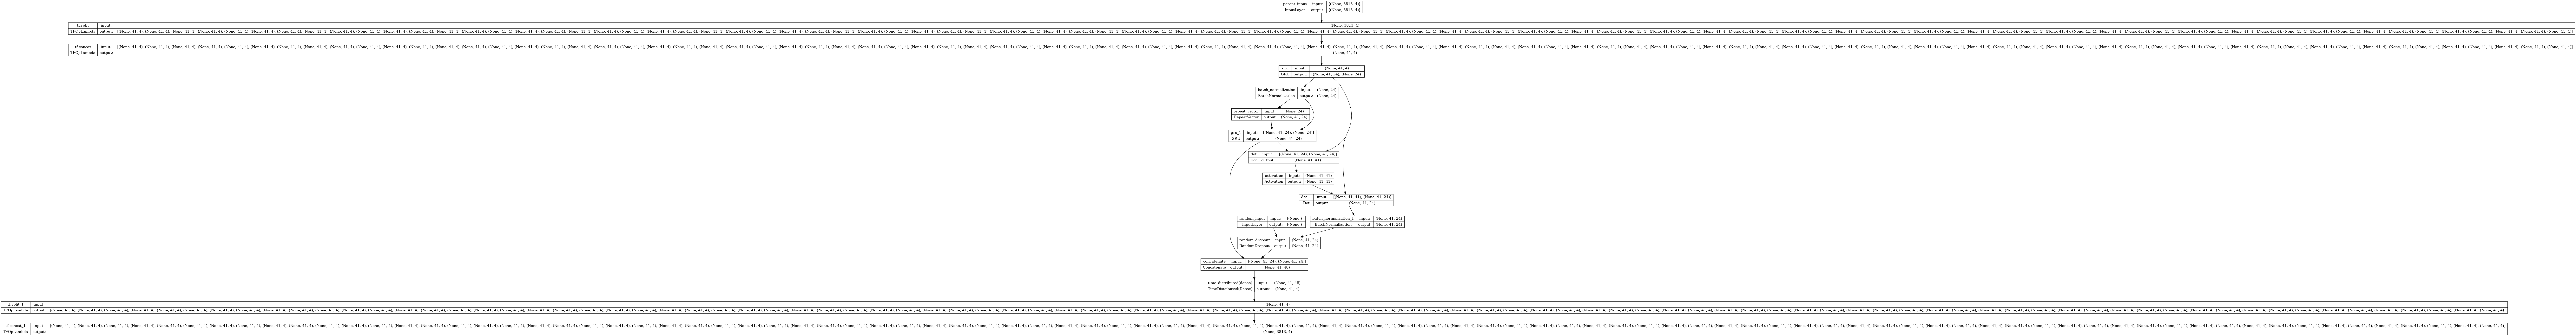

In [26]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [27]:
batch_size = 64      # Batch size for training.
patience = 25        # Patience for EarlyStop
epochs = 500         # Number of epochs to train for.
rand_rate = np.full((len(X_data)), 0.05)

In [28]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X_data, rand_rate ], Y_data, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

hist = history.history

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

2023-04-16 22:14:06.232068: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1262377536 exceeds 10% of free system memory.
2023-04-16 22:14:06.926730: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1262377536 exceeds 10% of free system memory.
2023-04-16 22:14:07.641022: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1262377536 exceeds 10% of free system memory.
2023-04-16 22:14:08.153622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1262377536 exceeds 10% of free system memory.


Epoch 1/500


2023-04-16 22:14:20.394558: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb7a00598d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-16 22:14:20.394654: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-04-16 22:14:20.829824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-16 22:14:29.043790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-16 22:14:30.232368: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-04-16 22:14:30.579666: I ./tensorflow/compiler/jit/device_compiler

  1/324 [..............................] - ETA: 2:01:32 - loss: 1.4719 - accuracy: 0.2465

2023-04-16 22:14:31.339163: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



324/324 [==============================] - 72s 154ms/step - loss: 1.1127 - accuracy: 0.4856 - val_loss: 0.8719 - val_accuracy: 0.6074
Epoch 2/500
324/324 [==============================] - 49s 151ms/step - loss: 0.8447 - accuracy: 0.6147 - val_loss: 0.7025 - val_accuracy: 0.6888
Epoch 3/500
324/324 [==============================] - 49s 151ms/step - loss: 0.7684 - accuracy: 0.6515 - val_loss: 0.6345 - val_accuracy: 0.7257
Epoch 4/500
324/324 [==============================] - 49s 151ms/step - loss: 0.7259 - accuracy: 0.6733 - val_loss: 0.5856 - val_accuracy: 0.7565
Epoch 5/500
324/324 [==============================] - 49s 151ms/step - loss: 0.6975 - accuracy: 0.6873 - val_loss: 0.5593 - val_accuracy: 0.7687
Epoch 6/500
324/324 [==============================] - 49s 151ms/step - loss: 0.6803 - accuracy: 0.6957 - val_loss: 0.5376 - val_accuracy: 0.7797
Epoch 7/500
324/324 [==============================] - 49s 151ms/step - loss: 0.6656 - accuracy: 0.7031 - val_loss: 0.5286 - val_accurac

Epoch 57/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4992 - accuracy: 0.7898 - val_loss: 0.3204 - val_accuracy: 0.8862
Epoch 58/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4970 - accuracy: 0.7910 - val_loss: 0.3267 - val_accuracy: 0.8836
Epoch 59/500
324/324 [==============================] - 49s 152ms/step - loss: 0.5036 - accuracy: 0.7881 - val_loss: 0.3212 - val_accuracy: 0.8867
Epoch 60/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4966 - accuracy: 0.7912 - val_loss: 0.3131 - val_accuracy: 0.8888
Epoch 61/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4942 - accuracy: 0.7924 - val_loss: 0.3599 - val_accuracy: 0.8614
Epoch 62/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4982 - accuracy: 0.7907 - val_loss: 0.3161 - val_accuracy: 0.8865
Epoch 63/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4919 - accuracy: 0.7935 - val_loss: 0

324/324 [==============================] - 49s 153ms/step - loss: 0.4571 - accuracy: 0.8117 - val_loss: 0.2749 - val_accuracy: 0.9129
Epoch 113/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4562 - accuracy: 0.8121 - val_loss: 0.2743 - val_accuracy: 0.9126
Epoch 114/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4559 - accuracy: 0.8122 - val_loss: 0.2703 - val_accuracy: 0.9120
Epoch 115/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4555 - accuracy: 0.8124 - val_loss: 0.2808 - val_accuracy: 0.9079
Epoch 116/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4566 - accuracy: 0.8119 - val_loss: 0.2756 - val_accuracy: 0.9136
Epoch 117/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4556 - accuracy: 0.8123 - val_loss: 0.2697 - val_accuracy: 0.9157
Epoch 118/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4544 - accuracy: 0.8128 - val_loss: 0.2694 -

324/324 [==============================] - 49s 152ms/step - loss: 0.4476 - accuracy: 0.8169 - val_loss: 0.2586 - val_accuracy: 0.9181
Epoch 168/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4525 - accuracy: 0.8148 - val_loss: 0.2618 - val_accuracy: 0.9133
Epoch 169/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4424 - accuracy: 0.8191 - val_loss: 0.2614 - val_accuracy: 0.9162
Epoch 170/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4411 - accuracy: 0.8196 - val_loss: 0.2574 - val_accuracy: 0.9166
Epoch 171/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4421 - accuracy: 0.8192 - val_loss: 0.2651 - val_accuracy: 0.9135
Epoch 172/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4450 - accuracy: 0.8179 - val_loss: 0.2619 - val_accuracy: 0.9143
Epoch 173/500
324/324 [==============================] - 50s 153ms/step - loss: 0.4412 - accuracy: 0.8197 - val_loss: 0.2636 -

324/324 [==============================] - 50s 153ms/step - loss: 0.4391 - accuracy: 0.8208 - val_loss: 0.2569 - val_accuracy: 0.9134
Epoch 223/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4440 - accuracy: 0.8187 - val_loss: 0.2579 - val_accuracy: 0.9151
Epoch 224/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4400 - accuracy: 0.8204 - val_loss: 0.2560 - val_accuracy: 0.9175
Epoch 225/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4393 - accuracy: 0.8207 - val_loss: 0.2568 - val_accuracy: 0.9182
Epoch 226/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4381 - accuracy: 0.8213 - val_loss: 0.2537 - val_accuracy: 0.9193
Epoch 227/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4406 - accuracy: 0.8202 - val_loss: 0.2525 - val_accuracy: 0.9198
Epoch 228/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4900 - accuracy: 0.8005 - val_loss: 0.3642 -

324/324 [==============================] - 49s 152ms/step - loss: 0.4303 - accuracy: 0.8253 - val_loss: 0.2447 - val_accuracy: 0.9218
Epoch 278/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4284 - accuracy: 0.8262 - val_loss: 0.2430 - val_accuracy: 0.9234
Epoch 279/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4338 - accuracy: 0.8238 - val_loss: 0.2501 - val_accuracy: 0.9179
Epoch 280/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4335 - accuracy: 0.8240 - val_loss: 0.2461 - val_accuracy: 0.9215
Epoch 281/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4328 - accuracy: 0.8243 - val_loss: 0.2570 - val_accuracy: 0.9140
Epoch 282/500
324/324 [==============================] - 49s 153ms/step - loss: 0.4300 - accuracy: 0.8256 - val_loss: 0.2493 - val_accuracy: 0.9182
Epoch 283/500
324/324 [==============================] - 50s 153ms/step - loss: 0.4304 - accuracy: 0.8255 - val_loss: 0.2667 -

324/324 [==============================] - 49s 153ms/step - loss: 0.4255 - accuracy: 0.8279 - val_loss: 0.2388 - val_accuracy: 0.9286
Epoch 333/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4256 - accuracy: 0.8280 - val_loss: 0.2352 - val_accuracy: 0.9284
Epoch 334/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4229 - accuracy: 0.8291 - val_loss: 0.2340 - val_accuracy: 0.9307
Epoch 335/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4303 - accuracy: 0.8258 - val_loss: 0.2468 - val_accuracy: 0.9228
Epoch 336/500
324/324 [==============================] - 50s 153ms/step - loss: 0.4231 - accuracy: 0.8291 - val_loss: 0.2379 - val_accuracy: 0.9275
Epoch 337/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4274 - accuracy: 0.8272 - val_loss: 0.2412 - val_accuracy: 0.9267
Epoch 338/500
324/324 [==============================] - 49s 152ms/step - loss: 0.4257 - accuracy: 0.8281 - val_loss: 0.2405 -

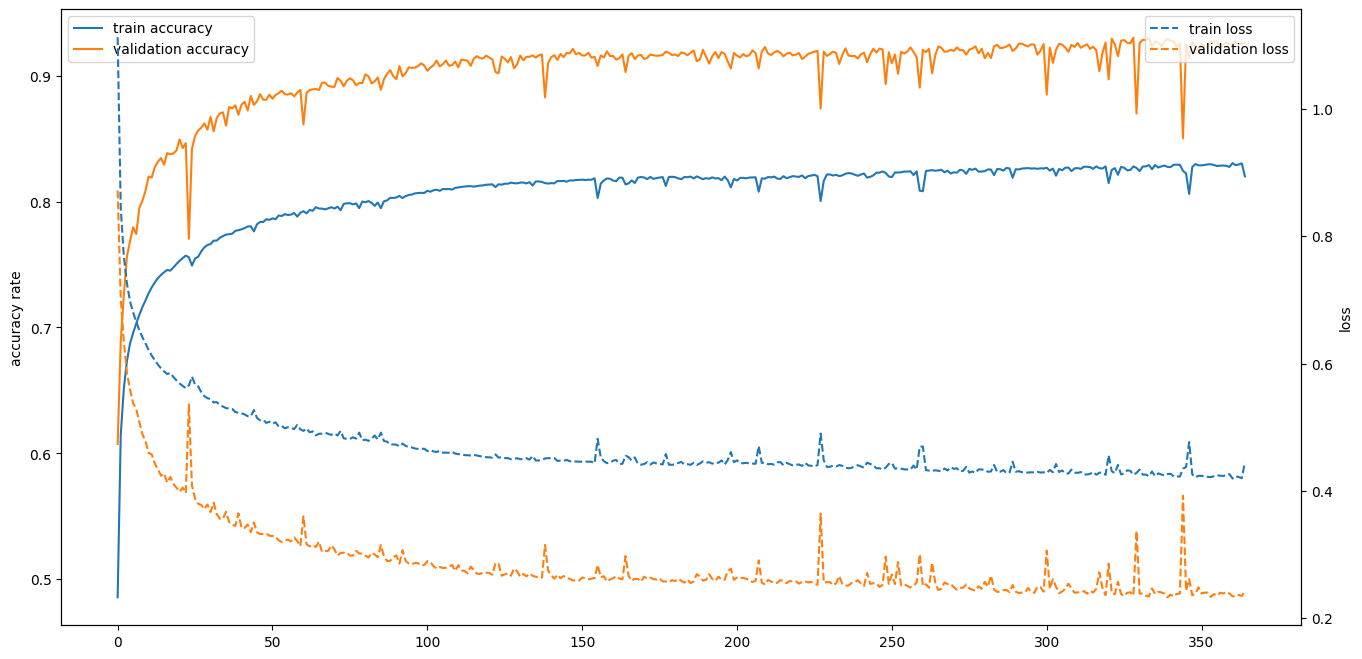

In [35]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(hist['accuracy'], '-', color='C0', label = 'train accuracy')
ax1.plot(hist['val_accuracy'], '-', color='C1', label = 'validation accuracy')

ax1.set_ylabel('accuracy rate')
ax1.legend(loc='upper left')

ax2.plot(hist['loss'], '--', color="C0", label = 'train loss')
ax2.plot(hist['val_loss'], '--', color="C1", label = 'validation loss')

ax2.set_ylabel('loss')
ax2.legend(loc='upper right')

plt.xlabel('epoch')
plt.show()

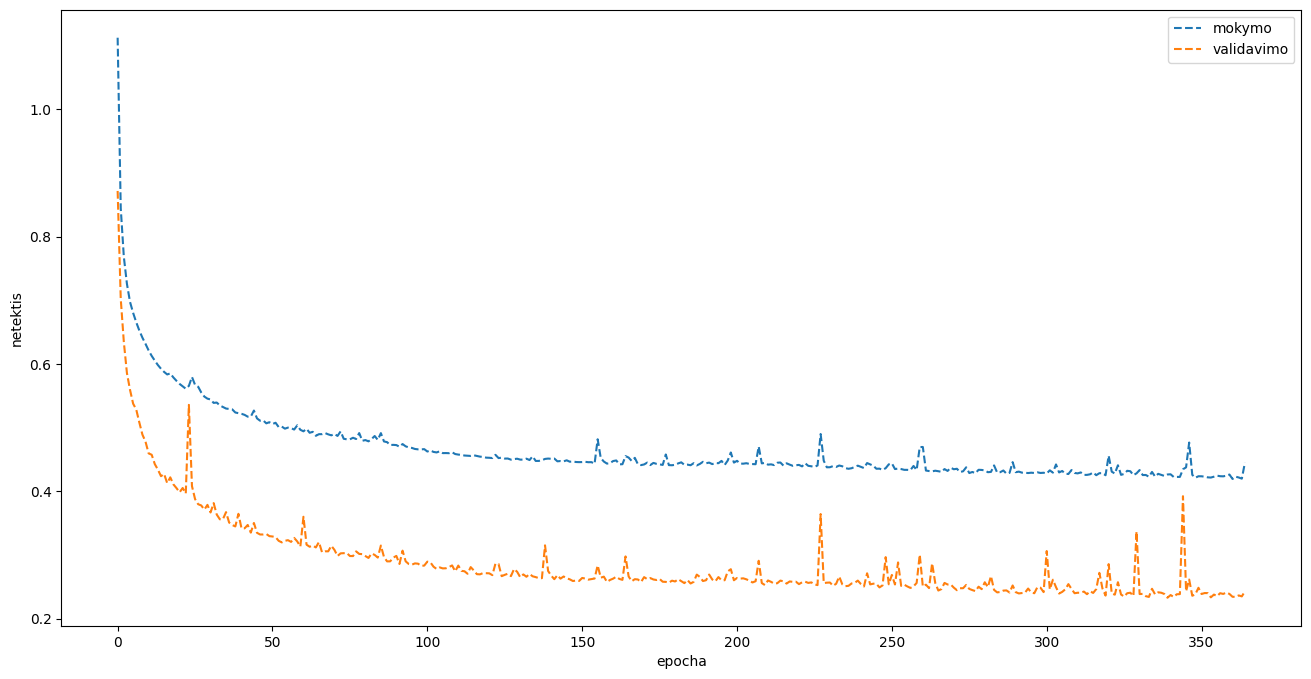

In [36]:
plt.plot(hist['loss'], '--', label = 'mokymo')
plt.plot(hist['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [37]:
model.save("data/ncbi_03/model_gru_32_24_V2")

2023-04-17 08:08:29.767749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,24]
	 [[{{node while/Placeholder_2}}]]
2023-04-17 08:08:29.831150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,24]
	 [[{{node while/Placeholder_2}}]]
2023-04-17 08:08:29.847228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and sh

2023-04-17 08:08:30.922739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'parent_input' with dtype float and shape [?,3813,4]
	 [[{{node parent_input}}]]
2023-04-17 08:08:30.961851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,3813,4]
	 [[{{node inputs_0}}]]
2023-04-17 08:08:30.975527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,3813,4]
	 [[{{node 

INFO:tensorflow:Assets written to: data/ncbi_03/model_gru_32_24_V2/assets


In [41]:
import json

with open("data/ncbi_03/model_gru_32_24_V2_history.json", "w") as f:
    json.dump(hist, f)